# Setup

In [27]:
# Core 
import datetime
import os
import glob

# Analysis 
import xarray as xr
import numpy as np
import pyproj as pp
import scipy as sp
import metpy as mp

# Plotting 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as mticker
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors


# Debugging 
import pdb
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Surface Reflectivity

In [73]:
CPOL = xr.open_mfdataset('/g/data/rr5/CPOL_radar/CPOL_level_2_1km/REFLECTIVITY/CPOL_REFLECTIVITY_201612*.nc').load()

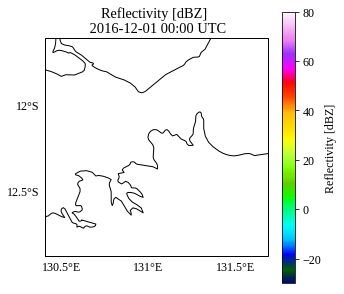

In [225]:
# Initialise fonts
rcParams.update({'font.family' : 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset' : 'dejavuserif'}) 
rcParams.update({'font.size': 12})

# Initialise figure
plt.ioff()
plt.close('all')
fig = plt.figure(figsize=(5,5))

# Define map boundaries
lat_min = CPOL.latitude.min()
lat_max = CPOL.latitude.max()
lon_min = CPOL.longitude.min()
lon_max = CPOL.longitude.max()

# Set up cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(
    [lon_min, lon_max, lat_min, lat_max], 
    crs=ccrs.PlateCarree()
)
ax.coastlines(resolution='10m')

# Find times when there is moderate reflectivity
ref_times = (CPOL.reflectivity > 20).any(dim = ['latitude','longitude'])
ref_times = ref_times.where(ref_times, drop=True)
ref_times = ref_times.time.values

dbz_contour = ax.pcolormesh(
    CPOL.longitude, CPOL.latitude, CPOL.reflectivity.sel(time = ref_times[0]),
    cmap='gist_ncar', transform=ccrs.PlateCarree(), vmin=-30, vmax=80,
)
cbar_w = plt.colorbar(dbz_contour, orientation='vertical')
cbar_w.set_label('Reflectivity [dBZ]')

# Draw grid (not working because of clearing collections in loop)
grid = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.4, linestyle='--',
)

grid.xlabels_top = False
grid.ylabels_right = False

grid.xlocator = mticker.FixedLocator(
    np.arange(np.floor(lon_min), np.ceil(lon_max)+1, 0.5)
)
grid.ylocator = mticker.FixedLocator(
    np.arange(np.floor(lat_min), np.ceil(lat_max)+1, 0.5)
)

grid.xformatter = LONGITUDE_FORMATTER
grid.yformatter = LATITUDE_FORMATTER

# Make labels
date_time = str(CPOL.time.values[0])[:10] + ' ' + str(CPOL.time.values[0])[11:16] + ' UTC'
plt.title('Reflectivity [dBZ] \n {}'.format(date_time))
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Create directory for saving figures
dt=str(datetime.datetime.now())[0:-7]
dt=dt.replace(" ", "_")
dt=dt.replace(":", "_")
dt=dt.replace("-", "")         

directory = '/g/data/w40/esh563/CPOL_analysis/figures/dbz_' + dt

os.mkdir(directory)

# pdb.set_trace()

# Define animation update function
def update(i):
    
    # Clear collections to correct animation issue.
    ax.collections = []
    
    print('Drawing frame {}.'.format(str(i).zfill(2)),  end='\r')

    dbz_contour = ax.pcolormesh(
        CPOL.longitude, CPOL.latitude, CPOL.reflectivity.sel(time = ref_times[i]), 
        vmin=-30, vmax=80, cmap='gist_ncar', transform=ccrs.PlateCarree(), animated=True
    ) 
    
    # Update title
    date_time = str(ref_times[i])[:10] + ' ' + str(ref_times[i])[11:16] + ' UTC'
    plt.title('Reflectivity [dBZ] \n {}'.format(date_time))
        
    # Save frame
    plt.savefig(
        directory + '/{}.png'.format(str(i))
    )

    return dbz_contour, ax

# Create and save animation
anim = FuncAnimation(
    fig, update, interval=200,
    frames=np.arange(0, ref_times.size)
)

anim.save(directory + '/relectivity.gif', dpi=80, writer='imagemagick')